# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - Frequent bus stops
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to calculate the distance from the orginal node of a sample point to the nearest pois (in this case, it is the frequent bus stops loaded from gtfs data). The accessibility score is integrated into the sample point dataframe based on the node id, the accessibility score is then transformed into a dummy variable with 1 for bus stops within 1600m of the original nodes of samples points, and 0 as bus stops beyond 1600m distance.

### Process:
1. Load frequent bus stop data from folder
2. Load the OSM graphml and create network via Pandana
3. Calculate accessibility to the amenity pois we retrieved from OSM.
    - the output results are the distance of orginal nodes to the nearest pois
4. connect the accessibility score to sample point dataframe
    - accessibility score is calculated as 1=distance to the nearest pois are within 1600m; 0=distance to the nearest pois are beyond 1600m



In [6]:
from setup_local_analysis import *
from setup_OSMnetwork import *
from config import *

import pandana #pandana on python 3.6
from pandana.loaders import osm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


pandana.__path__

['/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana']

In [2]:
# get bounding box from study region boundary shapefile
# get the 10 km buffered study region to consider the edge effects
bbox = get_bufferedstudyregion_bbox(boundary_filepath, crs=crs, to_crs=to_crs, to_latlong=True)

# check the shapefile format, study region boundary shapefile should specify lat lon geometry
# Bounding box should be formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]
print(bbox)

[32.414715167745996, -113.44197628074733, 34.13836571274371, -110.93231493458158]


## 1. Load frequent bus stop data from folder


In [3]:
bus_stop_gdf = gpd.GeoDataFrame.from_csv(frequent_stop_filepath)
bus_stop_gdf = bus_stop_gdf.rename(columns={'stop_lat':'lat', 'stop_lon':'lon'})
bus_stop_gdf.head()

,route_type,stop_id,stop_name,lat,lon,geometry
0,3,7125,Van Buren St & 21st Av,33.451319,-112.105049,POINT (-112.1050493 33.45131936)
1,3,20011,40th St & Elwood St,33.414488,-111.995519,POINT (-111.9955192 33.41448848)
2,3,9384,40th St & Cholla St,33.589620,-111.995879,POINT (-111.9958789 33.58961953)
3,3,3797,24th St & Campbell Av,33.501490,-112.030343,POINT (-112.0303433 33.50149027)
4,3,30139,Ray Rd & Hamilton St,33.320840,-111.833390,POINT (-111.83339 33.32084)


## 2. Load the OSM graphml and create network via Pandana

Reference:
[gdf node and edge attribute](https://automating-gis-processes.github.io/2018/notebooks/L6/network-analysis.html)  
[Pandana Network function](https://udst.github.io/pandana/tutorial.html)  
** Pandana is agnostic to the coordinate system. Use your local coordinate system or longitude then latitude - either one will work. (in this example, we use network graph with local coordinate system (unprojected))


In [4]:
network = get_pandana_network(G_filename=G_filename, folder=OSM_folder, bbox=bbox)

Network with 387,620 nodes loaded from graphml in 627.25 secs


## 3. Calculate accessibility to the amenity we retrieved

** make sure the loaded network is the same project as the pois dataframe

In [7]:
all_access = get_nearest_node_to_pois(pandana_network=network, pois_df=bus_stop_gdf, distance=distance, num_pois=num_pois)
all_access.head()

387,620 nodes in 61.32 secs


,1
41196323,1600.0
41196519,1600.0
41201620,1600.0
41201628,1600.0
41201668,1600.0


### Plot accessibility from each node to any amenity

In [8]:
# keyword arguments to pass for the matplotlib figure
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10)}
# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}
# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'
# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}
# keyword arguments to pass to make the colorbar
cbar_kwargs = {}
# keyword arguments to pass to basemap
bmap_kwargs = {}
# color to make the background of the axis
bgcolor = 'k'

Text(0.5,1,'Walking distance (1600m) to frequent bus stops, phoenix')

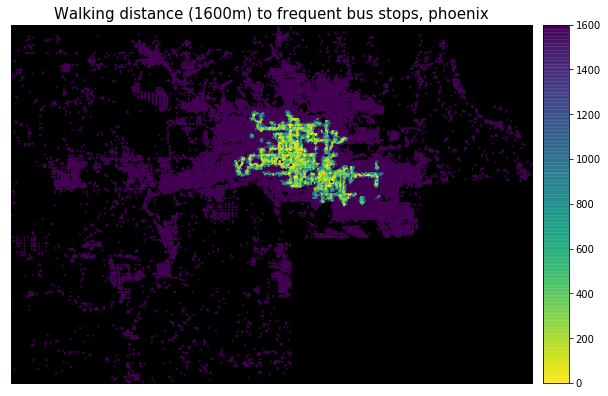

In [11]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance ({}m) to {}, {}'.format(distance, 'frequent bus stops', placename), fontsize=15)
#fig.savefig('images/accessibility-bus-phx.png', dpi=200, bbox_inches='tight')

## 4. Integrate the accessibility score in sample point dataframe

In [12]:
# load previously saved sample point dataframe
sample_points_stats = gpd.GeoDataFrame.from_file(samplepoint_stats_shapefile_path)

In [15]:
sample_points_df = add_access_score_to_df(all_access, sample_points_stats, distance, col_name='Paces_bus')

In [16]:
sample_points_df.head()

,index,Series,access,area,bridge,highway,junction,key,landuse,lanes,...,area_km,intct_coun,intct_den,node_dist,node_id,Baces_shop,Baces_bus,Paces_shop,geometry,Paces_bus
0,54610,POINT (396967.1469090146 3740937.651037707),None,None,None,residential,None,0,None,2,...,4.202586298544065,460.0,109.45640786944968,7987.048941485871,4434405703,1.0,1.0,1.0,POINT (396967.1469090146 3740937.651037707),1.0
1,218415,POINT (411790.7844599574 3695150.251553984),None,None,None,service,None,0,None,None,...,4.166059824150664,396.0,95.05384385130203,42380.5731190627,2303399221,1.0,1.0,1.0,POINT (411790.7844599574 3695150.251553984),1.0
2,218175,POINT (410822.3388440209 3687841.029634873),None,None,None,residential,None,0,None,None,...,3.31997933647271,284.0,85.54270108853567,30182.64805588144,5656668566,0.0,1.0,0.0,POINT (410822.3388440209 3687841.029634873),1.0
3,387236,POINT (397099.3676261376 3713319.001533487),None,None,None,service,None,0,None,2,...,3.62234042141883,398.0,109.87371524957553,7438.278863855303,1680775105,1.0,1.0,1.0,POINT (397099.3676261376 3713319.001533487),1.0
4,29304,POINT (392011.3783512853 3731108.331369997),None,None,None,residential,None,0,None,None,...,0.04354245748329371,2.0,45.93218012022762,29804.860826780863,3504602457,0.0,0.0,0.0,POINT (392011.3783512853 3731108.331369997),0.0


In [17]:
# save sample point stats dataframe
ox.save_gdf_shapefile(sample_points_df, filename='{studyregion}_urban_sample_points_stats{suffix}'.format(
        studyregion = placename, suffix = suffix), folder=OSM_folder)